in this notebook we:
* stage 2a - rescaled images, training from scratch on 384x512 images (the unfrozen part)

In [1]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

import wandb
from wandb.fastai import WandbCallback

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import configparser

from functions_wandb import *

In [2]:
%matplotlib inline

In [3]:
wandb.init(project="gabon")

W&B Run: https://app.wandb.ai/jedrzej/gabon/runs/19wnwr2w

In [4]:
# PATH_TO_IMG = Path("/data_rescaled")

# PATH_TO_MAIN = Path("/home/jupyter/")
# PATH_TO_TRAIN_DF = PATH_TO_MAIN / "inspect_data_split_validation"
# PATH_TO_MODELS = PATH_TO_MAIN / "training" / "saved_models"
# PATH_TO_CONFIG = PATH_TO_MAIN / "config"

# CONFIG = configparser.ConfigParser()
# CONFIG.read(PATH_TO_CONFIG / "neptune.ini")

In [5]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")

classes = df.species.unique()
print(len(classes)) # no "Mammal_Other"
classes

28


array(['Human', 'Blank', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey',
       'Duiker_Red', 'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [6]:
len(df.uniqueName)

347120

In [7]:
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [8]:
df["uniqueName"] = df.uniqueName.apply(lambda x: "resc_" + x)
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,resc_0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,resc_0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,resc_0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,resc_0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,resc_0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [9]:
%%time
data = get_training_data(df, (384, 512), batch_size=32)#, partial_pct=0.01)

CPU times: user 3.75 s, sys: 256 ms, total: 4.01 s
Wall time: 3.21 s


CPU times: user 5.45 s, sys: 1.14 s, total: 6.59 s
Wall time: 5.32 s


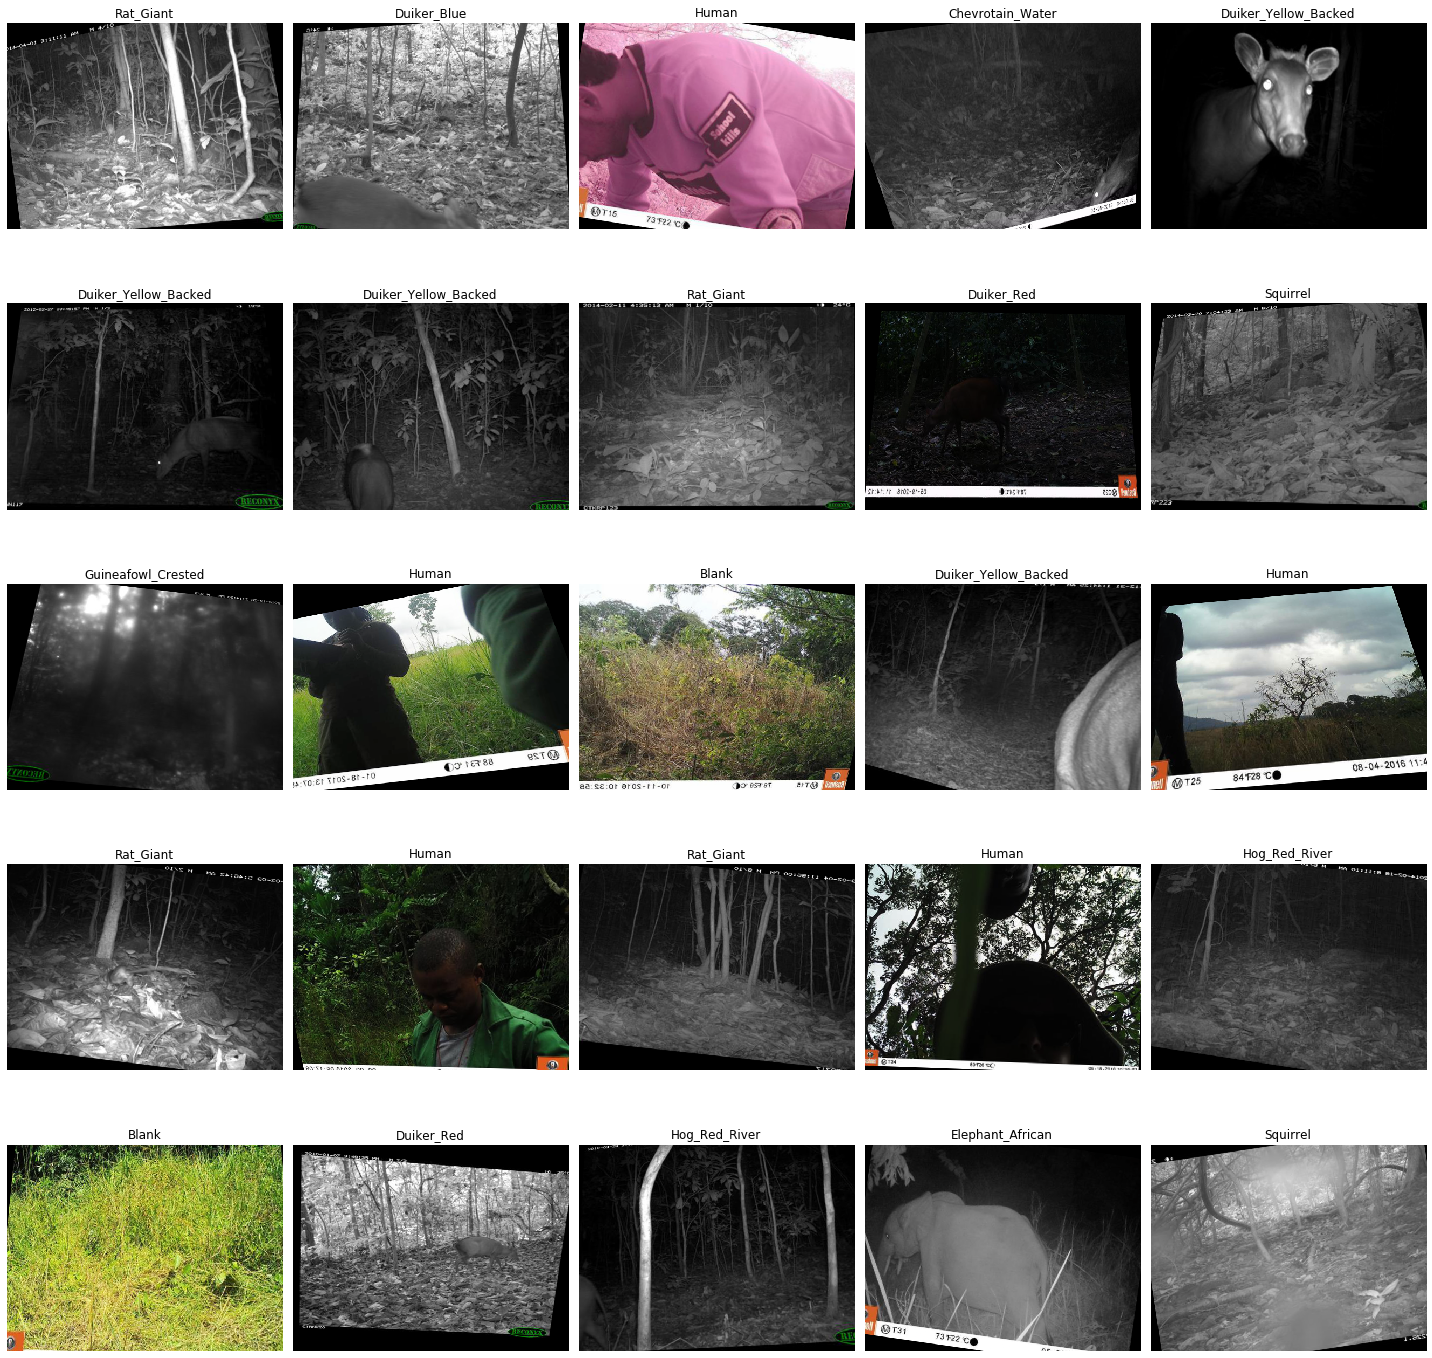

In [10]:
%%time
data.show_batch()

# Stage 2a

In [11]:
learn = get_initial_learner(data)
learn.load(PATH_TO_MODELS / "stage1a-5epochs-384_512-rescaled");

In [12]:
learn.unfreeze()

In [13]:
%%time
run_find_lr(learn, "stage2a-5epochs-384_512-rescaled")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/opt/anaconda3/lib/python3.7/site-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



CPU times: user 17.3 s, sys: 7.58 s, total: 24.9 s
Wall time: 42.2 s


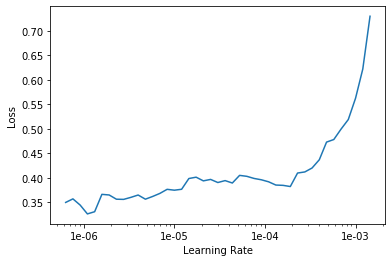

In [14]:
learn.recorder.plot()

In [15]:
initial_lr = 1e-3
lr = 1e-6 * 2
lr_end = initial_lr / 10
n_epochs =  5

In [16]:
%%time
run_training(learn, "stage2a-5epochs-384_512-rescaled", lr=lr, lr_end=lr_end, n_epochs=n_epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.390913,0.974975,0.737646,1:26:53
1,0.360016,0.909725,0.753897,1:05:53
2,0.274554,0.845854,0.770812,1:05:33
3,0.213978,0.906149,0.765747,1:05:03
4,0.197337,0.880298,0.769277,1:05:13


Better model found at epoch 0 with valid_loss value: 0.9749748706817627.
Better model found at epoch 1 with valid_loss value: 0.9097250699996948.
Better model found at epoch 2 with valid_loss value: 0.8458542823791504.
Loaded best saved model from /home/jupyter/training/wandb/run-20200313_230750-19wnwr2w/bestmodel.pth
CPU times: user 2h 58min 9s, sys: 1h 3min 11s, total: 4h 1min 20s
Wall time: 5h 48min 46s


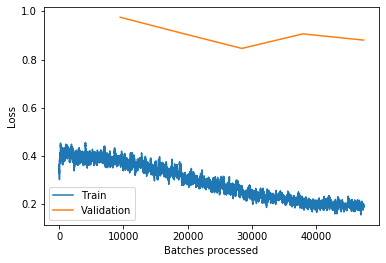

In [17]:
learn.recorder.plot_losses()

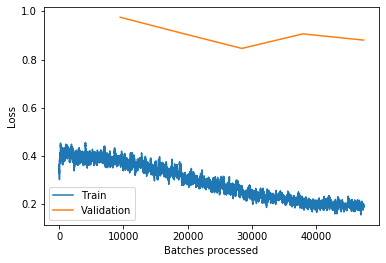

In [18]:
fig = learn.recorder.plot_losses(return_fig=True)
fig.savefig("loss_plot-stage2a-5epochs-384_512-rescaled.png")

### Load model and investigate results

In [19]:
# learn = get_initial_learner(data)
# learn.load(PATH_TO_MODELS / "stage6-5epochs-384_512-rescaled");

In [20]:
# wandb.init(project="gabon")

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

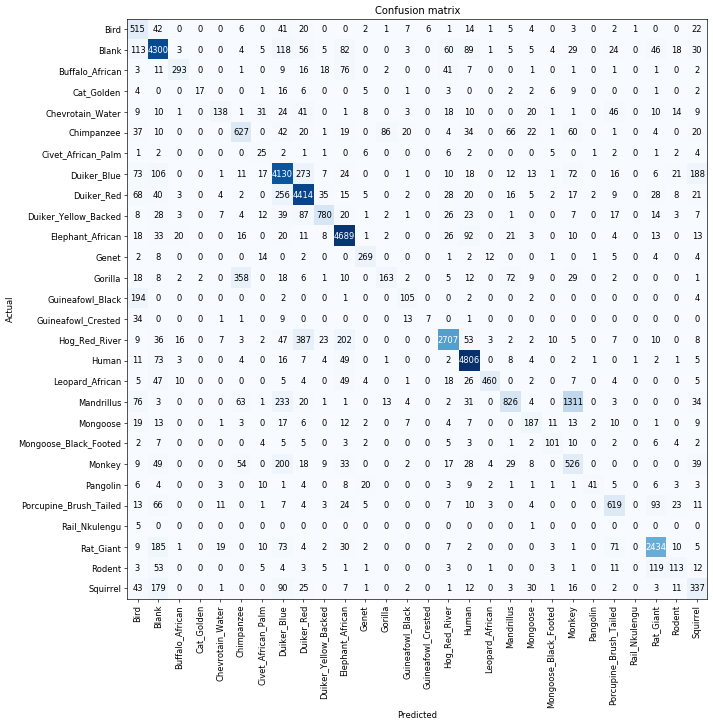

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
conf_m = interp.confusion_matrix()
np.save("conf_m-stage2a-5epochs-384_512-rescaled.npy", conf_m)

In [24]:
len(conf_m)

28

In [25]:
correct_p = sum([conf_m[i,i] for i in range(len(conf_m))])
correct_p

33629

In [26]:
all_p = conf_m.sum().sum()
all_p

43628

In [27]:
print(f"accuracy is: {round(100 * correct_p / all_p,2)}%")

accuracy is: 77.08%


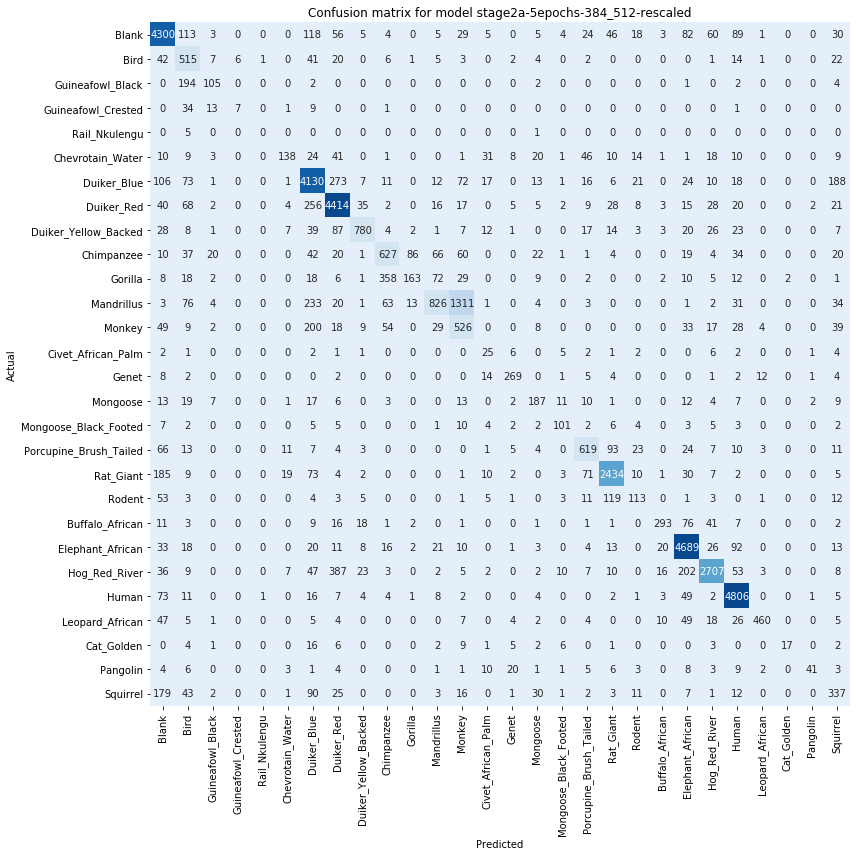

In [28]:
new_order = np.load("new_order.npy")
plot_conf_matrix_reordered(conf_m, 
                           sorted(classes),
                           new_order,
                           save_as = "conf_m-new_order-stage2a-5epochs-384_512-rescaled.png",
                           for_model = "stage2a-5epochs-384_512-rescaled")

In [29]:
preds = learn.get_preds(with_loss=True)
torch.save(preds, "preds-stage2a-5epochs-384_512-rescaled.pt")
preds

[tensor([[4.6560e-08, 8.7178e-08, 1.7141e-07,  ..., 8.8375e-09, 1.1516e-08,
          7.8649e-10],
         [5.6613e-06, 8.5108e-04, 7.0022e-06,  ..., 4.5152e-03, 2.2992e-05,
          7.8514e-06],
         [5.0955e-08, 9.9908e-01, 1.1298e-06,  ..., 9.6359e-08, 3.9606e-07,
          1.6927e-07],
         ...,
         [5.5203e-08, 1.0877e-07, 6.9357e-08,  ..., 1.0326e-07, 9.6139e-09,
          3.6428e-08],
         [9.8681e-02, 1.3292e-03, 4.3274e-05,  ..., 1.7022e-04, 7.8663e-05,
          3.4801e-02],
         [1.9499e-05, 9.2775e-05, 3.0667e-06,  ..., 3.2713e-06, 4.4004e-05,
          2.1881e-03]]),
 tensor([16, 23,  1,  ...,  9, 27, 18]),
 tensor([2.8730e-03, 1.7178e-02, 9.1701e-04,  ..., 5.5192e-05, 3.3581e+00,
         2.9341e+00])]

In [30]:
images_list = data.valid_ds.items
np.save("images_list-stage2a-5epochs-384_512-rescaled.pt", images_list)

In [31]:
images_list

array(['/data_rescaled/resc_1039759.jpg', '/data_rescaled/resc_1195784.jpg', '/data_rescaled/resc_0880576.jpg',
       '/data_rescaled/resc_1194852.jpg', ..., '/data_rescaled/resc_1186961.jpg', '/data_rescaled/resc_1203146.jpg',
       '/data_rescaled/resc_1227618.jpg', '/data_rescaled/resc_1229185.jpg'], dtype='<U32')